In [1]:
# %env DRJIT_LIBLLVM_PATH /usr/lib/x86_64-linux-gnu/libLLVM-15.0.7.so.1
# !echo $DRJIT_LIBLLVM_PATH

In [2]:
# %%bash
# ln -sf /usr/lib/x86_64-linux-gnu/libstdc++.so.6 ${CONDA_PREFIX}/lib/libstdc++.so.6
# export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/

In [3]:
import sys
sys.path.insert(0, '/home/jonathan/Documents/mi3-balance/build/python')

import drjit as dr
import mitsuba as mi
from drjit.auto import Float, UInt
import time

mi.set_variant('cuda_ad_rgb')
# mi.set_variant('llvm_ad_rgb')

In [4]:
from furnace_scene import make_scene_textured, visualize_scene

tex_fp = "/home/jonathan/Documents/mi3-balance/resources/data/common/textures/carrot.png"
# tex_fp = "/home/jonathan/Documents/mi3-balance/resources/data/common/textures/noise_02.png"
# tex_fp = "/home/jonathan/Documents/mi3-balance/resources/data/common/textures/museum.exr"
# tex_fp = "/home/jonathan/Documents/mi3-balance/scripts/resources/bird.bmp"

scene = make_scene_textured(tex_fp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..4.4187946].


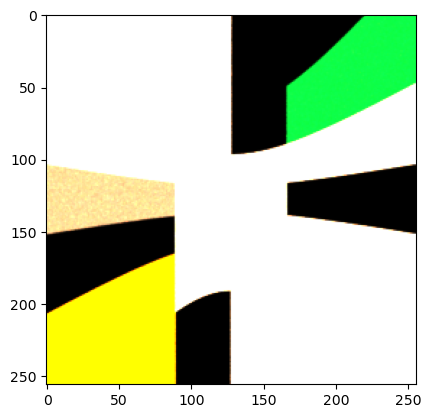

In [5]:
image = mi.render(scene)

import matplotlib.pyplot as plt
plt.imshow(image)

In [6]:
from radiosity import SceneSurfaceSampler, RadianceCacheMITSUBA, compute_loss
from train import define_BSDF_textured

NUM_WI_DIRECTIONS  = 256 << 0   # 32
SAMPLES_PER_RAY_LI = 64  << 0   # 32
SAMPLES_PER_RAY_LO = 128 << 0   # 128
NUM_GEO_SAMPLES = 1 << 8    # 128

scene_sampler = SceneSurfaceSampler(scene)
radiance_cache = RadianceCacheMITSUBA(scene, 
                                      spp_per_wo=SAMPLES_PER_RAY_LO, 
                                      spp_per_wi=SAMPLES_PER_RAY_LI)


bsdf_train, key = define_BSDF_textured(tex = mi.Bitmap(tex_fp))
x_init = mi.traverse(bsdf_train)[key]
x_ref = mi.traverse(scene)['mysphere.bsdf.reflectance.data']
print(dr.allclose(x_init,x_ref))

compute_loss(scene_sampler, radiance_cache, bsdf_train, 
        NUM_GEO_SAMPLES, NUM_WI_DIRECTIONS, 0)

True


[0.462362]

In [7]:
def pretty_print_log(logs):
    # logs = [log for log in logs if log.get('execution_time', 0) >= 0.05]
    # Iterate through the logs and format each log entry
    for entry in logs:
        print("-" * 80)
        for key, value in entry.items():
            # Check for special cases (like StringIO objects)
            if isinstance(value, str) and value.startswith('<_io.StringIO'):
                value = "StringIO object"
            print(f"{key:20}: {value}")
        print("-" * 80)


In [8]:
# Initialize BSDF to train
# bsdf_train, key = define_BSDF_textured(tex_size=(64, 64))
bsdf_train, key = define_BSDF_textured(tex = mi.Bitmap(tex_fp))

params = mi.traverse(bsdf_train)
opt = mi.ad.Adam(lr=0.05)
dr.enable_grad(params[key])
opt[key] = params[key]
params.update(opt)

x0 = params[key].numpy()

losses = []
for it in range(200):
    time1 = time.time()

    # Evaluate the objective function for the current BSDF params
    loss = compute_loss(scene_sampler, radiance_cache, bsdf_train, 
        NUM_GEO_SAMPLES, NUM_WI_DIRECTIONS, it)

    # Backpropagate through the rendering process
    dr.backward(loss)

    # Optimizer: take a gradient descent step
    opt.step()

    # Post-process the optimized parameters to ensure legal color values.
    opt[key] = dr.clip(opt[key], 0.0, 1.0)

    # Update the scene state to the new optimized values
    params.update(opt)

    losses.append(loss.numpy())
    time2 = time.time()
    print(f"Iteration {1+it:03d} [{time2 - time1:2f}]: Loss = {loss}")

Iteration 001 [0.046529]: Loss = [2.22375]
Iteration 002 [0.044845]: Loss = [2.1427]
Iteration 003 [0.043904]: Loss = [2.01125]
Iteration 004 [0.043037]: Loss = [1.91374]
Iteration 005 [0.041930]: Loss = [1.68056]
Iteration 006 [0.041900]: Loss = [1.67079]
Iteration 007 [0.042174]: Loss = [1.44691]
Iteration 008 [0.042639]: Loss = [1.34968]
Iteration 009 [0.041863]: Loss = [1.21887]
Iteration 010 [0.042076]: Loss = [1.23084]
Iteration 011 [0.042024]: Loss = [1.09371]
Iteration 012 [0.041976]: Loss = [1.05594]
Iteration 013 [0.042326]: Loss = [0.889229]
Iteration 014 [0.042362]: Loss = [0.867251]
Iteration 015 [0.041605]: Loss = [0.718499]
Iteration 016 [0.042967]: Loss = [0.726857]
Iteration 017 [0.041638]: Loss = [0.758133]
Iteration 018 [0.042489]: Loss = [0.608091]
Iteration 019 [0.041671]: Loss = [0.520765]
Iteration 020 [0.042095]: Loss = [0.440156]
Iteration 021 [0.042140]: Loss = [0.470391]
Iteration 022 [0.042255]: Loss = [0.46752]
Iteration 023 [0.042774]: Loss = [0.413205]
It

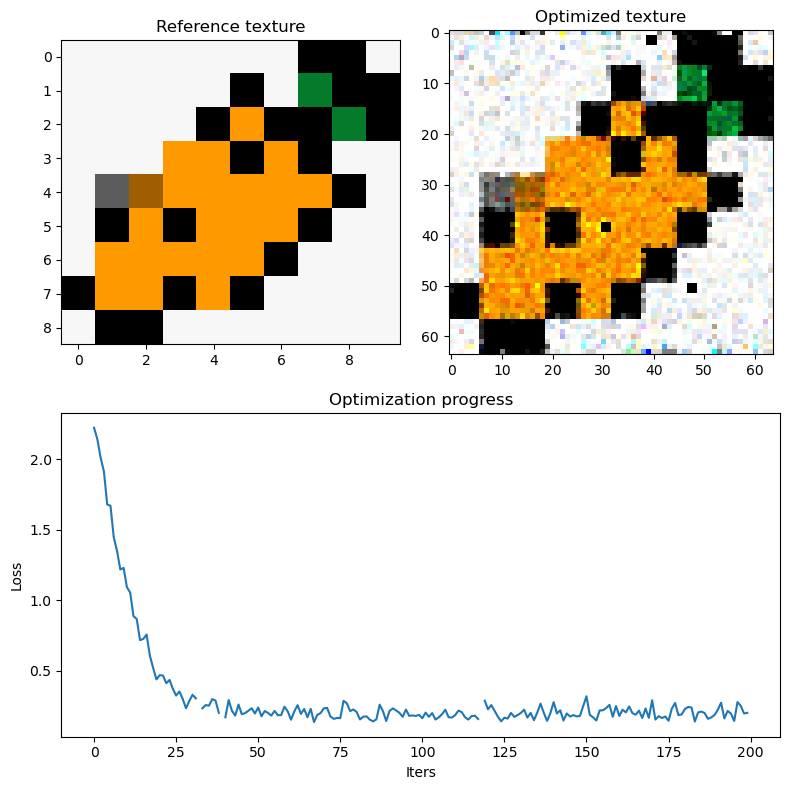

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from utils import grayscale_to_color

plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.title("Reference texture")
texture_ref = mi.traverse(scene)['mysphere.bsdf.reflectance.data']
mi.Bitmap(texture_ref).write("reference.exr")
plt.imshow(grayscale_to_color(texture_ref))
plt.subplot(2,2,2)
plt.title("Optimized texture")
texture_out = mi.TensorXf(params[key])
plt.imshow(texture_out)
mi.Bitmap(texture_out).write("optimized.exr")

plt.subplot(2,1,2)
plt.title("Optimization progress")
plt.plot(np.array(losses))
plt.xlabel("Iters")
plt.ylabel("Loss")
plt.tight_layout()